In [5]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"  # so the IDs match nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"] = "1"  # "0, 1" for multiple
# http://forums.fast.ai/t/tip-limiting-tensorflow-to-one-gpu/1995

In [6]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import scipy
import skimage.transform

import keras

from keras import backend as K  # set the data format as 'channels_first'

from keras.utils.data_utils import get_file
from keras.utils import np_utils
from keras.utils.np_utils import to_categorical

from keras import applications  # VGG model

from keras.models import Sequential, Model
from keras.layers import Input, Embedding, Reshape, merge, LSTM, Bidirectional, concatenate
from keras.layers import TimeDistributed, Activation, SimpleRNN, GRU, GlobalAveragePooling2D
from keras.layers.core import Flatten, Dense, Dropout, Lambda
#from keras.regularizers import l2, activity_l2, l1, activity_l1

from keras.layers.normalization import BatchNormalization
from keras.optimizers import SGD, RMSprop, Adam
#from keras.utils.layer_utils import layer_from_config
from keras.metrics import categorical_crossentropy, categorical_accuracy

from keras.layers.convolutional import *
from keras.preprocessing import image, sequence
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.text import Tokenizer

from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard  # callbacks

from glob import glob
import os
import bcolz
import ujson as json
import PIL

from scipy import ndimage
from collections import defaultdict

# import h5py

In [13]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [7]:
PATH_IMAGES = "/home/julien/tractable_images/"

## Create datasets (run only once)

In [179]:
df = pd.read_csv('./flwing_part-big_split.csv')
# There are a lot of duplicates (by image_id), we need to remove them.
df = df.drop_duplicates("image_id")

In [180]:
# We also remove all of the images which are in the csv file,
# but not in the directory.
all_images = os.listdir(PATH_IMAGES)
s = set(list(df["image_id"])) - set([x[:-4] for x in all_images])
df = df[~df["image_id"].isin(s)]

In [181]:
# Check that the csv contains the same number of images
# as the directory: 486713.
df.shape

(486713, 5)

In [182]:
df = df.drop(["b'imbag_id'", "set:"], axis=1)

In [183]:
df_flwing = df[df['flwing']==1]
df_not_flwing = df[df['flwing']==0]

In [184]:
val1 = df_flwing.sample(5000)
val2 = df_not_flwing.sample(5000)
val = pd.concat([val1, val2])
#del val1; del val2

df_flwing = df_flwing.drop(val1.index)
df_not_flwing = df_not_flwing.drop(val2.index)

In [185]:
test1 = df_flwing.sample(5000)
test2 = df_not_flwing.sample(5000)
test = pd.concat([test1, test2])
#del val1; del val2

df_flwing = df_flwing.drop(test1.index)
df_not_flwing = df_not_flwing.drop(test2.index)

In [213]:
for image in list(val1["image_id"]):
    os.rename(PATH_IMAGES+"{}.jpg".format(image),
             PATH_IMAGES+"val/flwing/{}.jpg".format(image))

for image in list(val2["image_id"]):
    os.rename(PATH_IMAGES+"{}.jpg".format(image),
             PATH_IMAGES+"val/not_flwing/{}.jpg".format(image))

In [212]:
for image in list(test1["image_id"]):
    os.rename(PATH_IMAGES+"{}.jpg".format(image),
             PATH_IMAGES+"test/flwing/{}.jpg".format(image))

for image in list(test2["image_id"]):
    os.rename(PATH_IMAGES+"{}.jpg".format(image),
             PATH_IMAGES+"test/not_flwing/{}.jpg".format(image))

In [206]:
for image in list(df_flwing["image_id"]):
    os.rename(PATH_IMAGES+"{}.jpg".format(image),
             PATH_IMAGES+"train/flwing/{}.jpg".format(image))

for image in list(df_not_flwing["image_id"]):
    os.rename(PATH_IMAGES+"{}.jpg".format(image),
             PATH_IMAGES+"train/not_flwing/{}.jpg".format(image))

### Visualization (useful cells, keep them for later)

In [7]:
# dossier avec les images.
# ./tractable_images

In [84]:
import matplotlib.pyplot as plt

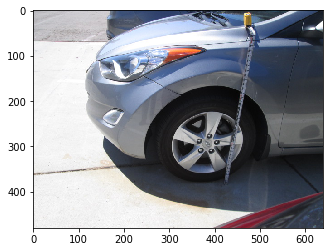

In [85]:
index = 25
image = plt.imread('./tractable_images/{}.jpg'.format(df.iloc[index]['image_id']))
plt.imshow(image)

## Classifier (resize)

In [8]:
batch_size = 64
target_size = (224,224)

In [9]:
# From
# https://stackoverflow.com/questions/50486678/crop-the-center-of-the-image-in-keras-imagedatagenerator-or-flow-from-directory

img_height = 480
img_width = 640
def center_crop(batches, crop_length):
  while True:
    batch_x, batch_y = next(batches)
    start_y = (img_height - crop_length) // 2
    start_x = (img_width - crop_length) // 2
    if K.image_data_format() == 'channels_last':
        batch_crops = batch_x[:, start_x:(img_width - start_x), start_y:(img_height - start_y), :]
    else:
        batch_crops = batch_x[:, :, start_x:(img_width - start_x), start_y:(img_height - start_y)]
    yield (batch_crops, batch_y)

In [6]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        #featurewise_center=True,
        #featurewise_std_normalization=True,
        width_shift_range=0.125,
        height_shift_range=0.125,
        fill_mode='constant', cval=0.,
        shear_range=0.2,
        zoom_range=(0.7, 1.2),
        rotation_range=25
)

train_generator = train_datagen.flow_from_directory(
    directory=PATH_IMAGES+"train/",
    target_size=(480,640),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True
)

train_crops = center_crop(train_generator, 224)

Found 466713 images belonging to 2 classes.


In [17]:
# x_batch, y_batch = next(train_generator)

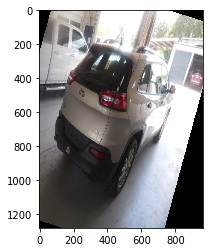

In [18]:
# plt.imshow(x_batch[0])

In [7]:
valid_datagen = ImageDataGenerator(
        rescale=1./255,
        #featurewise_center=True,
        #featurewise_std_normalization=True,
        width_shift_range=0.125,
        height_shift_range=0.125,
        fill_mode='constant', cval=0.,
        shear_range=0.2,
        zoom_range=(0.7, 1.2),
        rotation_range=25
)

valid_generator = valid_datagen.flow_from_directory(
    directory=PATH_IMAGES+"val/",
    target_size=(480,640),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True
)

valid_crops = center_crop(valid_generator, 224)

Found 10000 images belonging to 2 classes.


In [27]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    directory=PATH_IMAGES+"test/",
    target_size=(480,640),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

test_crops = center_crop(test_generator, 224)

Found 10000 images belonging to 2 classes.


In [219]:
train_generator.n

466713

In [19]:
base_model = applications.VGG16(include_top=False, weights='imagenet')#, input_shape=(3,)+target_size)

i=0
for layer in base_model.layers:
    layer.trainable = False
    i = i+1
    print(i,layer.name)

1 input_3
2 block1_conv1
3 block1_conv2
4 block1_pool
5 block2_conv1
6 block2_conv2
7 block2_pool
8 block3_conv1
9 block3_conv2
10 block3_conv3
11 block3_pool
12 block4_conv1
13 block4_conv2
14 block4_conv3
15 block4_pool
16 block5_conv1
17 block5_conv2
18 block5_conv3
19 block5_pool


In [20]:
x = base_model.output
#x = Dense(128, activation='relu')(x)
x = GlobalAveragePooling2D()(x)
#x = Dropout(0.2)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
predictions = Dense(2, activation='sigmoid')(x)

In [313]:
# nf=128; p=0.5
# x = base_model.output
# #print(x.shape[1:])
# #x = BatchNormalization(axis=1, input_shape=x.shape[1:])(x)
# x = Convolution2D(nf,(3,3), activation='relu', padding='same')(x)
# x = Dropout(p)(x)
# #x = BatchNormalization(axis=1, input_shape=x.shape)(x)
# x = Convolution2D(nf,(3,3), activation='relu', padding='same')(x)
# x = Dropout(p)(x)
# #x = BatchNormalization(axis=1)(x)
# x = Convolution2D(nf,(3,3), activation='relu', padding='same')(x)
# x = Dropout(p)(x)
# #x = BatchNormalization(axis=1)(x)
# x = Convolution2D(2,(3,3), padding='same')(x)
# x = Dropout(p)(x)
# predictions = GlobalAveragePooling2D()(x)
# #x = GlobalAveragePooling2D()(x)
# #predictions = Activation('sigmoid')(x)

In [21]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [22]:
class_weight = {0: 5., 1: 1.}

In [23]:
#checkpointer = ModelCheckpoint(filepath=path+'results/models/top_model_high_res_640.hdf5',
#                               verbose=1, save_best_only=True)
checkpointer = ModelCheckpoint(filepath="classifier_cc.hdf5",
                               verbose=1, save_best_only=True)    
earlystop = EarlyStopping(monitor="val_loss", patience=10)
tensorboard = TensorBoard(log_dir="cc_logs")
callbacks_list = [checkpointer, earlystop, tensorboard]

In [ ]:
model = Model(inputs=base_model.input, outputs=predictions)

model.compile(loss="categorical_crossentropy", optimizer=Adam(lr=0.001), metrics=["accuracy"])


STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size  # 7292
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size  # 156
model.fit_generator(
        train_crops,
        steps_per_epoch=1823,
        epochs=100,
        #callbacks = callbacks_list,
        validation_data = valid_crops,
        validation_steps=52,
        class_weight=class_weight,
        callbacks=callbacks_list
        )

Epoch 1/100
 135/1823 [=>............................] - ETA: 1:44:59 - loss: 0.8836 - acc: 0.7920

/home/julien/miniconda3/envs/project/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:739: UserWarning: Possibly corrupt EXIF data.  Expecting to read 16843011 bytes but only got 0. Skipping tag 64249
  " Skipping tag %s" % (size, len(data), tag))
/home/julien/miniconda3/envs/project/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 10. 
  warnings.warn(str(msg))


 188/1823 [==>...........................] - ETA: 1:41:27 - loss: 0.8608 - acc: 0.7937

/home/julien/miniconda3/envs/project/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:790: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn("Image appears to be a malformed MPO file, it will be "


 594/1823 [========>.....................] - ETA: 1:16:16 - loss: 0.7888 - acc: 0.8107

/home/julien/miniconda3/envs/project/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:756: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 1. 
  warnings.warn(str(msg))


1823/1823 [==============================] - 6858s 4s/step - loss: 0.7268 - acc: 0.8290 - val_loss: 0.5178 - val_acc: 0.7290

Epoch 00001: val_loss improved from inf to 0.51778, saving model to classifier_cc.hdf5
Epoch 2/100
1055/1823 [================>.............] - ETA: 45:43 - loss: 0.6613 - acc: 0.8457

/home/julien/miniconda3/envs/project/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:739: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8589934590 bytes but only got 29023. Skipping tag 34855
  " Skipping tag %s" % (size, len(data), tag))


1282/1823 [====================>.........] - ETA: 32:16 - loss: 0.6588 - acc: 0.8477

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1823/1823 [==============================] - 6726s 4s/step - loss: 0.6193 - acc: 0.8558 - val_loss: 0.4187 - val_acc: 0.8044

Epoch 00005: val_loss improved from 0.42390 to 0.41873, saving model to classifier_cc.hdf5
Epoch 6/100
1823/1823 [==============================] - 6724s 4s/step - loss: 0.6105 - acc: 0.8625 - val_loss: 0.4145 - val_acc: 0.8030

Epoch 00006: val_loss improved from 0.41873 to 0.41446, saving model to classifier_cc.hdf5
Epoch 7/100
1823/1823 [==============================] - 6745s 4s/step - loss: 0.6152 - acc: 0.8582 - val_loss: 0.4454 - val_acc: 0.7852

Epoch 00007: val_loss did not improve from 0.41446
Epoch 8/100
1823/1823 [==============================] - 6761s 4s/step - loss: 0.6039 - acc: 0.8612 - val_loss: 0.3980 - val_acc: 0.8206

Epoch 00008: val_loss improved from 0.41446 to 0.39797, saving model to classifier_cc.hdf5
Epoch 9/100
 390/1823 [=====>........................] - ETA: 1:24:34 - loss: 0.5817 - acc: 0.8633

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1823/1823 [==============================] - 6745s 4s/step - loss: 0.5939 - acc: 0.8605 - val_loss: 0.4110 - val_acc: 0.8053

Epoch 00011: val_loss did not improve from 0.39797
Epoch 12/100
1823/1823 [==============================] - 6748s 4s/step - loss: 0.5854 - acc: 0.8628 - val_loss: 0.3944 - val_acc: 0.8241

Epoch 00012: val_loss improved from 0.39797 to 0.39438, saving model to classifier_cc.hdf5
Epoch 13/100
 729/1823 [==========>...................] - ETA: 1:04:59 - loss: 0.5719 - acc: 0.8688

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1823/1823 [==============================] - 6758s 4s/step - loss: 0.5863 - acc: 0.8630 - val_loss: 0.3849 - val_acc: 0.8210

Epoch 00015: val_loss improved from 0.39438 to 0.38487, saving model to classifier_cc.hdf5
Epoch 16/100
1823/1823 [==============================] - 6759s 4s/step - loss: 0.5826 - acc: 0.8661 - val_loss: 0.4132 - val_acc: 0.7969

Epoch 00016: val_loss did not improve from 0.38487
Epoch 17/100
1823/1823 [==============================] - 6766s 4s/step - loss: 0.5745 - acc: 0.8679 - val_loss: 0.4093 - val_acc: 0.8107

Epoch 00017: val_loss did not improve from 0.38487
Epoch 18/100
1823/1823 [==============================] - 6755s 4s/step - loss: 0.5812 - acc: 0.8641 - val_loss: 0.4074 - val_acc: 0.8192

Epoch 00018: val_loss did not improve from 0.38487
Epoch 19/100
1823/1823 [==============================] - 6736s 4s/step - loss: 0.5767 - acc: 0.8677 - val_loss: 0.3955 - val_acc: 0.8134

Epoch 00019: val_loss did not improve from 0.38487
Epoch 20/100
1823/1823 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1823/1823 [==============================] - 6700s 4s/step - loss: 0.5687 - acc: 0.8686 - val_loss: 0.3827 - val_acc: 0.8209

Epoch 00028: val_loss did not improve from 0.36680
Epoch 29/100
1823/1823 [==============================] - 6713s 4s/step - loss: 0.5621 - acc: 0.8715 - val_loss: 0.3814 - val_acc: 0.8269

Epoch 00029: val_loss did not improve from 0.36680
Epoch 30/100
1823/1823 [==============================] - 6721s 4s/step - loss: 0.5645 - acc: 0.8722 - val_loss: 0.3911 - val_acc: 0.8216

Epoch 00030: val_loss did not improve from 0.36680
Epoch 31/100
 745/1823 [===========>..................] - ETA: 1:03:48 - loss: 0.5610 - acc: 0.8716

In [344]:
STEP_SIZE_TRAIN, STEP_SIZE_VALID

(7292, 156)

In [26]:
import pickle
with open('./trainHistoryDict_cc.p', 'wb') as file_pi:
    pickle.dump(model.history.history, file_pi)

# model.save("./classifier_1.h5")

In [ ]:
# from keras.models import load_model

In [34]:
import pickle
with open('./trainHistoryDict_cc.p', 'rb') as file_pi:
    history = pickle.load(file_pi)

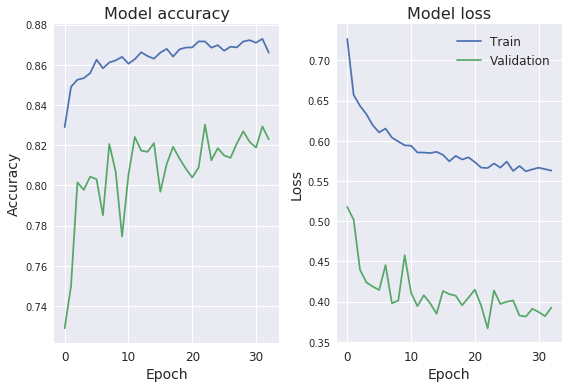

In [41]:
plt.style.use('seaborn')
# summarize history for accuracy
plt.subplot(1, 2, 1)
plt.plot(history['acc'])
plt.plot(history['val_acc'])
plt.title('Model accuracy', fontsize=16)
plt.ylabel('Accuracy', fontsize=14)
plt.xlabel('Epoch', fontsize=14)
#plt.legend(['Train', 'Validation'], loc='upper left', fontsize=12)
plt.xticks(fontsize=12)
#plt.show()
# summarize history for loss
plt.subplot(1, 2, 2)
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Model loss', fontsize=16)
plt.ylabel('Loss', fontsize=14)
plt.xlabel('Epoch', fontsize=14)
plt.legend(['Train', 'Validation'], loc='upper right', fontsize=12)
plt.xticks(fontsize=12)
plt.tight_layout()
plt.savefig("./visualizations/classifier_cc_training.png", dpi=200)#bbox_inches="tight", dpi=200)

In [10]:
from keras.models import load_model
model = load_model("classifier_cc.hdf5")

In [14]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    directory=PATH_IMAGES+"test/",
    target_size=(480,640),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

test_crops = center_crop(test_generator, 224)

Found 10000 images belonging to 2 classes.


In [15]:
model.evaluate_generator(
    test_crops,
    steps=156,
)

/home/julien/miniconda3/envs/project/lib/python3.6/site-packages/PIL/JpegImagePlugin.py:790: UserWarning: Image appears to be a malformed MPO file, it will be interpreted as a base JPEG file
  warnings.warn("Image appears to be a malformed MPO file, it will be "


[0.32879388122222364, 0.8500600961538461]

In [22]:
test_datagen_heatmaps_150 = ImageDataGenerator(rescale=1./255)

test_generator_heatmaps_150 = test_datagen_heatmaps_150.flow_from_directory(
    directory="/home/julien/crops_heatmaps/",
    target_size=(480,640),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

test_crops_heatmaps_150 = center_crop(test_generator_heatmaps_150, 224)

Found 10000 images belonging to 2 classes.


In [23]:
model.evaluate_generator(
    test_crops_heatmaps_150,
    steps=156,
)

[0.8322990204279239, 0.594551282051282]

In [24]:
test_datagen_heatmaps_100 = ImageDataGenerator(rescale=1./255)

test_generator_heatmaps_100 = test_datagen_heatmaps_100.flow_from_directory(
    directory="/home/julien/crops_heatmaps_2/",
    target_size=(480,640),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

test_crops_heatmaps_100 = center_crop(test_generator_heatmaps_100, 224)

Found 10000 images belonging to 2 classes.


In [25]:
model.evaluate_generator(
    test_crops_heatmaps_100,
    steps=156,
)

[0.5486936152745516, 0.7208533653846154]

In [26]:
test_datagen_heatmaps_50 = ImageDataGenerator(rescale=1./255)

test_generator_heatmaps_50 = test_datagen_heatmaps_50.flow_from_directory(
    directory="/home/julien/crops_heatmaps_3/",
    target_size=(480,640),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

test_crops_heatmaps_50 = center_crop(test_generator_heatmaps_50, 224)

Found 10000 images belonging to 2 classes.


In [27]:
model.evaluate_generator(
    test_crops_heatmaps_50,
    steps=156,
)

[0.367927301579561, 0.827323717948718]

In [42]:
test_datagen_frcnn = ImageDataGenerator(rescale=1./255)

test_generator_frcnn = test_datagen_frcnn.flow_from_directory(
    directory="/home/julien/crops_frcnn/",
    target_size=(480,640),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

test_crops_frcnn = center_crop(test_generator_frcnn, 224)

Found 10000 images belonging to 2 classes.


In [43]:
model.evaluate_generator(
    test_crops_frcnn,
    steps=156,
)

[0.743111944446961, 0.5987580128205128]